## Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from boundary import *
from tools import *
from oper import *

rtype = np.float32

## input parameters

In [19]:
## Setting parameter

nx = 201 
nz = 201
nt = 1001
npml = 20

dx = 10.
dz = 10.
dt = 1e-3

order = 2

## set model

In [20]:
vp=np.ones((nz,nx),rtype)*3000
rho=np.ones((nz,nx),rtype)*1.

In [21]:
nx_e = nx + 2*npml
nz_e = nz + 2*npml
a_x,a_xh,a_z,a_zh,b_x,b_xh,b_z,b_zh=gen_cpml(npml,fmax,dx,dt,nx_e,nz_e,rtype)

In [31]:
nx_e

241

In [22]:
vp_e = vel_exp(nx,nz,order,npml,rtype,vp)
rho_e = vel_exp(nx,nz,order,npml,rtype,rho)

In [23]:
vp_e = vp_e[order:order+nz_e,order:order+nx_e]
rho_e = rho_e[order:order+nz_e,order:order+nx_e]

In [28]:
vp_e.shape

(241, 241)

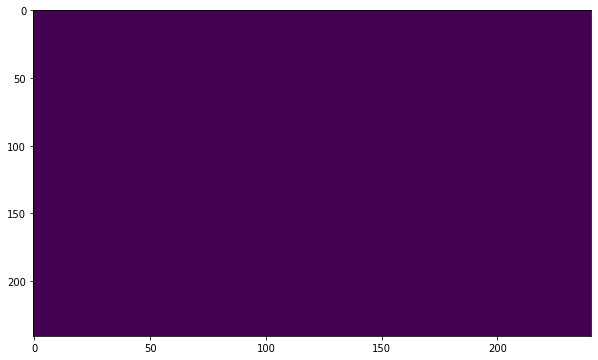

In [30]:
fig = plt.figure(figsize=(10,6))

plt.imshow(vp_e,aspect='auto')
plt.savefig('True_velocity.jpg')
    

## set source & receiver

In [37]:
nshot = 1
# sx = 100 + order + npml
# sz = 100 + order + npml

# rx = 2 + order
# rz = 2 + order


## shot
nshot = 1
fshot_x = 100
dshot_x = 0
fshot_z = 100
dshot_z = 0

## receiver
nrcv = nx
frcv_x = 2
drcv_x = 1
frcv_z = 2
drcv_z = 0


sx,sz = ass_shot(nshot,fshot_x,dshot_x,fshot_z,dshot_z,npml,order)
ishot = 0;
geom_ID = 1;

rx,rz = ass_rcv(ishot,nrcv,frcv_x,drcv_x,frcv_z,drcv_z,npml,order,geom_ID)


In [34]:
## Source

f0 = 5
fmax = f0*3

factor=1; t0=1.2/f0  
a=(np.pi*f0)**2
ricker=np.zeros((nt),rtype)
for it in np.arange(nt):
    dm = a*((it*dt-t0)**2)
    ricker[it] = factor*(1-(2*dm))*np.exp(-dm)
source=ricker


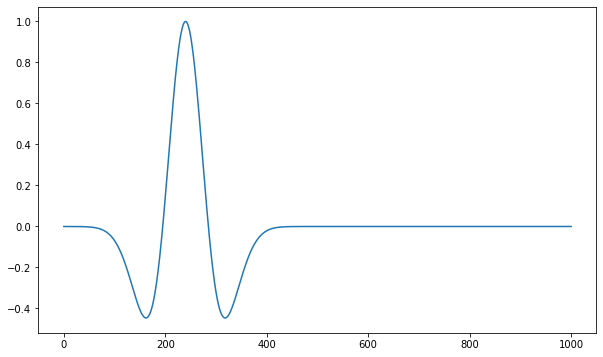

<Figure size 432x288 with 0 Axes>

In [35]:
fig = plt.figure(figsize=(10,6))

plt.plot(source)
plt.show()
plt.savefig('Source.jpg')

## 2D forward modeling

In [38]:
mnx = nx + order
mnz = nz + order

rho = np.ones((mnz, mnx), rtype)
u1 = np.zeros((mnz, mnx), rtype)
u2 = np.zeros_like(u1)
u3 = np.zeros_like(u1)
shot = np.zeros_like(u1)
shot[sz, sx] = 1
mvp = np.ones((mnz, mnx), rtype) * 3000
wavefield = np.zeros((mnz, mnx, nt), rtype)

In [40]:
C=np.array([1.12500000000000, -0.0416666666666667])

In [41]:
ss,wave=forward(ishot,vp_e,nx,nz,nt,npml,order,dx,dz,dt,source,
            sx,sz,rx,rz,
            nrcv,
            C,
           a_x,a_xh,a_z,a_zh,
           b_x,b_xh,b_z,b_zh,rtype)

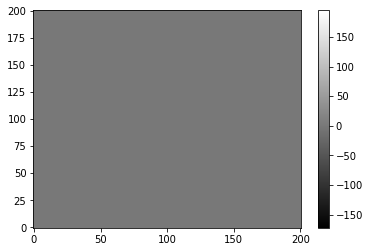

In [65]:
# plt.imshow(wave[100,:,:],aspect='auto')
wmin=np.min(wave); wmax=np.max(wave)
plt.imshow(wave[1000,order+npml:order+npml+nx,order+npml:order+npml+nz],aspect='auto', cmap='gray', origin='lower',vmin=wmin*0.1,vmax=wmax*0.1)
plt.colorbar()
plt.savefig('CPML_wave_1sec.jpg')

In [15]:
## Main loop
for t in range(nt):
    for i in range(1, mnx - 1):
        for j in range(1, mnz - 1):
            u3[j, i] = 2 * u2[j, i] - u1[j, i] + ((mvp[j, i] * dt) ** 2) * ((u2[j, i + 1] - 2 * u2[j, i] + u2[j, i - 1]) / dx ** 2 + (u2[j + 1, i] - 2 * u2[j, i] + u2[j - 1, i]) / dz ** 2)
            u3[j, i] = u3[j, i] + (dt ** 2) * (shot[j, i] * source[t])
    
    wavefield[:,:,t] = u3
    # Update time steps
    u1 = u2.copy()
    u2 = u3.copy()
    u3 = np.zeros((mnz, mnx), rtype)

# Plot the final solution
plt.imshow(u3, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

KeyboardInterrupt: 

In [ ]:
wmin=np.min(wavefield); wmax=np.max(wavefield)
fig = plt.figure(figsize=(10,6))

plt.imshow(wavefield[:,:,1000],aspect='auto', cmap='gray', origin='lower',vmin=wmin*0.1,vmax=wmax*0.1)
plt.colorbar()
plt.savefig('wave_1sec.jpg')
    

In [ ]:
wavefield